In [22]:
import numpy as np

In [24]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

In [25]:
import sys
sys.path.append('/home/manchun.yeung/microlensing/wolensing_simon/wolensing/')

In [26]:
from plot.plot import plot_contour
import amplification_factor.amplification_factor as af
from lensmodels.potential import potential

from jax import config
config.update("jax_enable_x64", True)
import numpy as np

The macroimage where the microlens is placed around.

In [27]:
type2 = True

In [28]:
ym = 0.8
angle = np.radians(float(0))

Importing constants

In [29]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

In [30]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [31]:
mL1 = 1e10
mL2 = 20
mtot = mL1 + mL2

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL1)
thetaE2 = param_processing(zL, zS, mL2)
thetaE = param_processing(zL, zS, mtot)

In [33]:
Mpc=3.085677581491367e+22
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.7, Om0=0.306, Tcmb0=2.725)
DL       = cosmo.angular_diameter_distance(zL)
DS       = cosmo.angular_diameter_distance(zS)
DLS      = cosmo.angular_diameter_distance_z1z2(zL, zS)
D        = DLS/(DL*DS)
print(np.float64(D/Mpc))

1.097926071881248e-26


In [34]:
from utils.utils import Einstein_radius

In [36]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]

kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE1 / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
if type2:
    microtype = np.nonzero(Td)[0][0]
else:
    microtype = np.where(Td==0)[0][0]

masses = np.linspace(0.5, 3, 6)
angle = [0, 150, 260]
ym = [1., .4, 4.]

# num_points = len(masses)
# for j in range(0,num_points):
#     theta_E = param_processing(zL, zS, masses[j])# lens model
#     #positioning the microlenses
#     eta20 = MacroImg_ra[microtype] + ym[j]*np.cos(np.radians(angle[j])) * theta_E
#     eta21 = MacroImg_dec[microtype] + ym[j] * np.sin(np.radians(angle[j])) * theta_E
#     lens_model_list.append('POINT_MASS')
#     kwargs_lens_list.append({'center_x': eta20, 'center_y': eta21, 'theta_E': theta_E})

mass_density = 200
from utils.lensing import *
radius = injection_radius(masses, mass_density) #rad
lens_model_list, kwargs_lens_list = field_injection(zL, zS, MacroImg_ra[microtype], MacroImg_dec[microtype], masses, radius, lens_model_list, kwargs_lens_list, seed=1)
    
# Injecting microlens around desired macroimage
# eta20, eta21 = MacroImg_ra[microtype] + np.cos(angle)*ym*thetaE2, MacroImg_dec[microtype] + np.sin(angle)*ym*thetaE2
# lens_model_list = ['SIS', 'POINT_MASS']
# kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
# kwargs_point_mass_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
# kwargs_lens_list = [kwargs_sis_1, kwargs_point_mass_2]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 20 * thetaE2,
                 'Pixels': 5*1e3,
                 # 'ÍmgIndex': 1,
                 'Optimization': True,
                 'Verbose': True,
                 'OverlapDist': 1e-18,
                 'OverlapDistMacro': 1e-17}
solver_kwargs.update({'Improvement' : 0.1})
solver_kwargs.update({'MinDist' : 10**(-7)})

Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                                      source_pos_y=beta1,
                                                                      lens_model_list=lens_model_list,
                                                                      kwargs_lens=kwargs_lens_list,
                                                                      **solver_kwargs)
# Images_dict = {'Source_ra': beta0,
#                'Source_dec': beta1,
#                'Img_ra': Img_ra,
#                'Img_dec': Img_dec,
#                'MacroImg_ra': MacroImg_ra,
#                'MacroImg_dec': MacroImg_dec,
#                'Microlens_ra': [eta20],
#                'Microlens_dec': [eta21],
#                'thetaE': thetaE}

# time delays, magnifications, Morse indices 
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
tds = TimeDelay(Img_ra, Img_dec,
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)
print('Time delays (seconds): ', tds)
print('magnifications: ', mus)
print('Morse indices: ', ns)
    
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]
if not isinstance(T0, float):
    T0 = T0[0]
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-4.02644403e-07  1.20793321e-06]
dec: [-4.23516474e-22 -4.23516474e-22]

potential [3.24245030e-13 9.72735092e-13]
prefactor 4.557193381334929e+17
[3.24245031e-13 3.24245031e-13]

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> False
Scaled                          --> False
SearchWindowMacro               --> 8.052888061582412e-06
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-17
NearSource                      --> False
Optimization 

In [37]:
# plot only the microimages around the desired macroimage
Img_ra = np.delete(Img_ra, [-1])
Img_dec = np.delete(Img_dec, [-1])

In [38]:
import os
filename = __file__
os.path.basename(filename).split('/')[-1]
np.savetxt(f'./data/{filename}_pos.txt', np.array([Img_ra, Img_dec]))

import json
with open(f'./data/{filename}_kwargs.txt', 'w') as fout:
    json.dump(kwargs_lens_list, fout)

In [40]:
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(MacroImg_ra[microtype], MacroImg_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]

[1.20792920e-06 1.20799538e-06 1.20792194e-06 1.20797616e-06
 1.20791467e-06 1.20796350e-06 1.20791103e-06] [-1.35768367e-11  3.91302353e-11 -3.87367374e-11  5.40140791e-13
  1.07936000e-11  3.54614970e-11  5.62728780e-11] Img_pos


<Axes: >

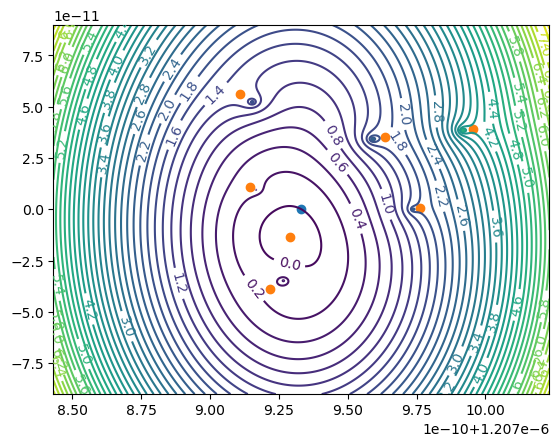

In [42]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
plot_contour(ax1, lens_model_list, MacroImg_ra[microtype], MacroImg_dec[microtype], 5*thetaE2, kwargs_lens_list, beta0, beta1, Img_ra, Img_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=True)
plt.savefig(f'./data/{filename}_tdpic.png')

In [43]:
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3


In [47]:
# Define the characteristic WindowSize
mL3 = 10
thetaE3 = param_processing(zL, zS, mL3)

In [48]:
import time

start


Integrating...:   0%|          | 0/441 [00:00<?, ?it/s]Integrating...: 100%|██████████| 441/441 [07:22<00:00,  1.00s/it]


[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.35162198e-22
 2.38665679e-22 2.39023177e-22]
49997 1 shi
total time 10.99999


<Figure size 640x480 with 0 Axes>

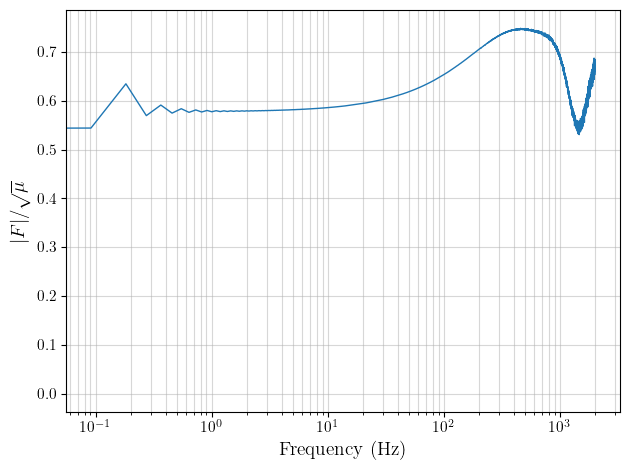

<Axes: xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [49]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu': np.abs(Mus[microtype]),
               }

kwargs_integrator = {'PixelNum': int(300000),
                     'PixelBlockMax': 2000,
                     'WindowSize': 10.*210*thetaE3,
                     'WindowCenterX': MacroImg_ra[microtype],
                     'WindowCenterY': MacroImg_dec[microtype],
                     'T0': T0,
                     'TimeStep': 1e-6/Tscale, 
                     'TimeMax': T0 + 7/Tscale,
                     'TimeMin': T0 - 5/Tscale,
                     'TExtend': 12/Tscale,
                     'LastImageT': 4e-7/Tscale,
                     'Tbuffer': 0./Tscale,
                     'Tscale': Tscale}


amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ts, Ft = amplification.integrator(gpu=False)
ws, Fws = amplification.fourier()

# Geometrical optics
To get the geometrical optics around type 1 image, we need the magnifications, time delay and the image positions of the microimages

In [44]:
tds = TimeDelay(Img_ra, Img_dec,
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)

potential [9.72731849e-13 9.72785141e-13 9.72726002e-13 9.72769667e-13
 9.72720144e-13 9.72759471e-13 9.72717212e-13]
prefactor 4.557193381334929e+17
[3.24241804e-13 3.24295099e-13 3.24235957e-13 3.24279623e-13
 3.24230099e-13 3.24269427e-13 3.24227168e-13]
0.08230423085983915 0.08230423085983915 time_delay
5.7713197180393365 5.7713197180393365 time_delay
1.7466879813791825 1.7466879813791825 time_delay
7.341548249974114 7.341548249974114 time_delay
-5.187851938444649 -5.187851938444649 time_delay
4.181845700992726 4.181845700992726 time_delay
-3.7451296394069638 -3.7451296394069638 time_delay


In [ ]:
geofs, geoFws = amplification.geometrical_optics(mus, tds, Img_ra, Img_dec, upper_lim=2000)

NameError: name 'amplification' is not defined

# Full amplification factor concatenated with geometrical optics
Given the computaional cost of the diffraction integral, we concatenate the result of wave optics at low frequency and geometrical optics at high frequency to obtain a full amplification factor with default upper bound of 3000Hz.

In [37]:
fac = np.sqrt(np.abs(Mus[microtype]))

In [38]:
plt.clf()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<Figure size 640x480 with 0 Axes>

In [39]:
from bisect import bisect_left
low_index = bisect_left(geofs, 1)
geofs = geofs[low_index:]
geoFws = geoFws[low_index:]
ws = ws[low_index:]
Fws = Fws[low_index:]

(1, 2000)

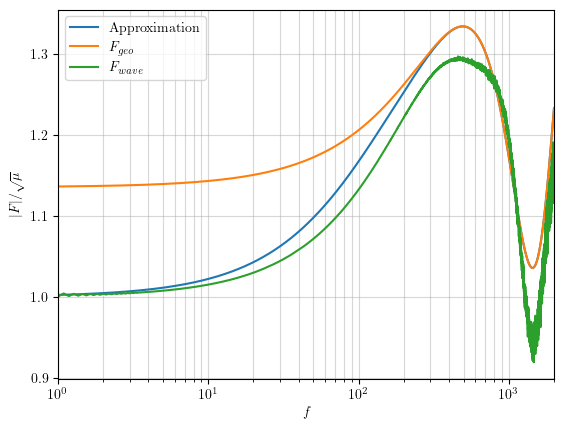

In [40]:
ww = geofs
plt.semilogx(geofs, (fac*np.exp(-ww*np.pi/188) + (1-np.exp(-ww*np.pi/188))*np.abs(geoFws))/fac, label='Approximation')
plt.semilogx(geofs, np.abs(geoFws)/fac,label=r'$F_{geo}$')
plt.semilogx(ws, np.abs(Fws)/fac, label=r'$F_{wave}$')
plt.ylabel(r'$|F|/\sqrt{\mu}$')
plt.xlabel(r'$f$')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlim(1, 2000)
plt.savefig(f'./{filename}_abs.png',bbox_inches='tight', dpi=300)

(1, 2000)

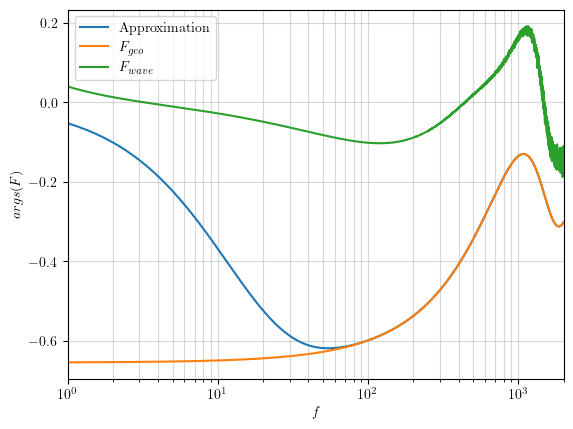

In [41]:
plt.semilogx(geofs, (1-np.exp(-ww*np.pi/37.5))*np.angle(geoFws), label='Approximation')
plt.semilogx(geofs, np.angle(geoFws),label=r'$F_{geo}$')
plt.semilogx(ws, np.angle(Fws), label=r'$F_{wave}$')
plt.ylabel(r'$args(F)$')
plt.xlabel(r'$f$')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlim(1, 2000)
plt.savefig(f'./{filename}_pha.png',bbox_inches='tight', dpi=300)